# Tutorial 7: ARGA & ARVGA  

Paper:
* [Adversarially Regularized Graph Autoencoder for Graph Embedding](https://www.ijcai.org/Proceedings/2018/0362.pdf)  

Code:
 * [ARGA & ARVGA](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/autoencoder.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/argva_node_clustering.py)

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


## Imports

In [3]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

In [4]:
use_cuda = False

## Define the dataset

Download the dataset

In [5]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

Processing...
Done!


Get the number of nodes

In [6]:
num_nodes = data.x.shape[0]

Create the train/val/test data

In [7]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

## Define the model

Define the encoder classes (the same as in `Tutorial 6`)

In [8]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

Define the discriminator class

In [9]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

Define the training algorithm

In [10]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    
    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)  
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
 
    loss = 0
    loss = loss + model.reg_loss(z)  # Comment
    
    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()
    
    return loss

Define a training test method

In [11]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

## Initialize the model

Initialize an encoder and a discriminator

In [12]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64, 
                              out_channels=1) # Comment

Initialize the model and move everything to the GPU

In [13]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

Define the optimizers

In [14]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

### Train the model

In [15]:
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

Epoch: 001, Loss: 5.462, AUC: 0.710, AP: 0.739, Completeness: 0.118, Homogeneity: 0.118, NMI: 0.118
Epoch: 002, Loss: 4.772, AUC: 0.680, AP: 0.714, Completeness: 0.091, Homogeneity: 0.090, NMI: 0.091
Epoch: 003, Loss: 4.237, AUC: 0.668, AP: 0.704, Completeness: 0.074, Homogeneity: 0.071, NMI: 0.072
Epoch: 004, Loss: 3.706, AUC: 0.665, AP: 0.700, Completeness: 0.079, Homogeneity: 0.075, NMI: 0.077
Epoch: 005, Loss: 3.361, AUC: 0.667, AP: 0.700, Completeness: 0.071, Homogeneity: 0.068, NMI: 0.069
Epoch: 006, Loss: 3.041, AUC: 0.674, AP: 0.703, Completeness: 0.083, Homogeneity: 0.078, NMI: 0.081
Epoch: 007, Loss: 2.740, AUC: 0.689, AP: 0.712, Completeness: 0.103, Homogeneity: 0.102, NMI: 0.102
Epoch: 008, Loss: 2.487, AUC: 0.706, AP: 0.725, Completeness: 0.130, Homogeneity: 0.132, NMI: 0.131
Epoch: 009, Loss: 2.323, AUC: 0.714, AP: 0.733, Completeness: 0.139, Homogeneity: 0.142, NMI: 0.140
Epoch: 010, Loss: 2.177, AUC: 0.722, AP: 0.743, Completeness: 0.149, Homogeneity: 0.150, NMI: 0.150


Epoch: 083, Loss: 4.044, AUC: 0.876, AP: 0.864, Completeness: 0.440, Homogeneity: 0.446, NMI: 0.443
Epoch: 084, Loss: 4.002, AUC: 0.878, AP: 0.866, Completeness: 0.443, Homogeneity: 0.449, NMI: 0.446
Epoch: 085, Loss: 3.997, AUC: 0.880, AP: 0.868, Completeness: 0.445, Homogeneity: 0.451, NMI: 0.448
Epoch: 086, Loss: 3.912, AUC: 0.882, AP: 0.871, Completeness: 0.450, Homogeneity: 0.456, NMI: 0.453
Epoch: 087, Loss: 3.941, AUC: 0.885, AP: 0.874, Completeness: 0.455, Homogeneity: 0.459, NMI: 0.457
Epoch: 088, Loss: 3.959, AUC: 0.886, AP: 0.876, Completeness: 0.462, Homogeneity: 0.467, NMI: 0.464
Epoch: 089, Loss: 4.057, AUC: 0.888, AP: 0.879, Completeness: 0.465, Homogeneity: 0.470, NMI: 0.467
Epoch: 090, Loss: 3.970, AUC: 0.889, AP: 0.881, Completeness: 0.464, Homogeneity: 0.469, NMI: 0.466
Epoch: 091, Loss: 4.002, AUC: 0.890, AP: 0.882, Completeness: 0.465, Homogeneity: 0.469, NMI: 0.467
Epoch: 092, Loss: 3.970, AUC: 0.891, AP: 0.883, Completeness: 0.455, Homogeneity: 0.459, NMI: 0.457


Epoch: 165, Loss: 3.475, AUC: 0.910, AP: 0.910, Completeness: 0.391, Homogeneity: 0.406, NMI: 0.399
Epoch: 166, Loss: 3.490, AUC: 0.909, AP: 0.910, Completeness: 0.383, Homogeneity: 0.398, NMI: 0.391
Epoch: 167, Loss: 3.477, AUC: 0.909, AP: 0.910, Completeness: 0.383, Homogeneity: 0.398, NMI: 0.390
Epoch: 168, Loss: 3.524, AUC: 0.908, AP: 0.909, Completeness: 0.380, Homogeneity: 0.395, NMI: 0.387
Epoch: 169, Loss: 3.537, AUC: 0.907, AP: 0.909, Completeness: 0.376, Homogeneity: 0.391, NMI: 0.384
Epoch: 170, Loss: 3.493, AUC: 0.906, AP: 0.908, Completeness: 0.372, Homogeneity: 0.388, NMI: 0.380
Epoch: 171, Loss: 3.520, AUC: 0.905, AP: 0.907, Completeness: 0.375, Homogeneity: 0.391, NMI: 0.383
Epoch: 172, Loss: 3.581, AUC: 0.904, AP: 0.906, Completeness: 0.372, Homogeneity: 0.389, NMI: 0.380
Epoch: 173, Loss: 3.584, AUC: 0.903, AP: 0.905, Completeness: 0.364, Homogeneity: 0.381, NMI: 0.372
Epoch: 174, Loss: 3.544, AUC: 0.902, AP: 0.904, Completeness: 0.369, Homogeneity: 0.386, NMI: 0.377


In [16]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


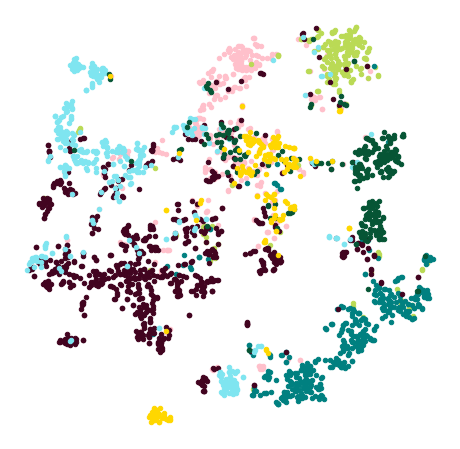

In [17]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)